### Time to get your hands dirty! Can a computer learn if we're going to detect gravitational waves?

This episode of "time to get your hands dirty" is about something I studied carefully in the past: gravitational-wave selection effects. This is one the LIGO interferometers:

![](https://www.ligo.caltech.edu/system/news_items/images/53/page/Virgo_aerial_view_01.jpg?1506530275)


All experiments have selection effects. Some sources are easier to detect than others which distorts the population of sources we observe (this crucial in astronomy! Surveys are typically flux limited). 
In order to decided if a feature in the observed population of objects is telling us something new about reality, we need to understand and model our selection effects (for instance: it would be wrong to say that all stars are close by just because we can't observe those that are very far!). In observational astronomy, this is known as [Malmquist bias](https://en.wikipedia.org/wiki/Malmquist_bias) and was first formulated in 1922.
 
**The goal here is to machine-learn the LIGO detectability: can we *predict* if a gravitational-wave source will be detected?**  

[This dataset](https://github.com/dgerosa/pdetclassifier/releases/download/v0.2/sample_2e7_design_precessing_higherordermodes_3detectors.h5) contains simulated gravitational-wave signals from merging black holes (careful the file size is >1 GB). If you've never seen them, the [.h5 format](https://en.wikipedia.org/wiki/Hierarchical_Data_Format) is a highly optimized storage strategy for large datasets. It's amazing. In python, you can read it with `h5py`.

In particular, each source has the following features:
- `mtot`: the total mass of the binary
- `q`: the mass ratio
- `chi1x`, `chi1y`, `chi1z`, `chi2x`, `chi2y`, `chi2z`: the components of the black-hole spins in a suitable reference frame.
- `ra`, `dec`: the location of the source in the sky
- `iota`: the inclination of the orbital plane'
- `psi`: the polarization angle (gravitational waves have two polarization states much like light)
- `z`: the redshift

The detectability is defined using the `snr` (signal-to-noise ratio) computed with a state-of-the-art model of the LIGO/Virgo detector network. Some (many?) of you will have studied this in Sesana's gravitational-wave course; [see here](https://arxiv.org/abs/1908.11170) for a nice write-up. All you need to know now is that we threshold the `snr` values and assume that LIGO will (not) see a source if `snr`>12 (`snr`<12). The resulting 0-1 labels are reported in the `det` attribute in the dataset.

Today's task is to train a classifier (you decide which one!) and separate sources that are detectables from those that aren't. 

Be creative! This is a challenge! Let's see who gets the  higher completeness and/or the smaller contamination (on a validation set, of course! Careful with overfitting here!).

*Tips*:
- You can downsample the data for debugging purposes
- You can also use only some of the features.

In [5]:
import matplotlib.pyplot as plt
import h5py
import numpy as np
from matplotlib import colors

from sklearn.linear_model import LogisticRegression
from astroML.utils import split_samples
from astroML.utils import completeness_contamination

In [6]:
data = h5py.File('../../sample_2e7_design_precessing_higherordermodes_3detectors.h5', 'r')
list(data.keys())

['chi1x',
 'chi1y',
 'chi1z',
 'chi2x',
 'chi2y',
 'chi2z',
 'dec',
 'det',
 'iota',
 'mtot',
 'psi',
 'q',
 'ra',
 'snr',
 'z']

#### I tried using more data but my computer struggles... As we can see in the learning curves adding data could improve my performance, as both cross validation and training error are going down

In [23]:
snr = data['snr'][:10000]
iota = data['iota'][:10000]
mtot= data['mtot'][:10000]
q = data['q'][:10000]
z = data['z'][:10000]
psi = data['psi'][:10000]
det =  data['det'][:10000]

print(len(snr))

10000


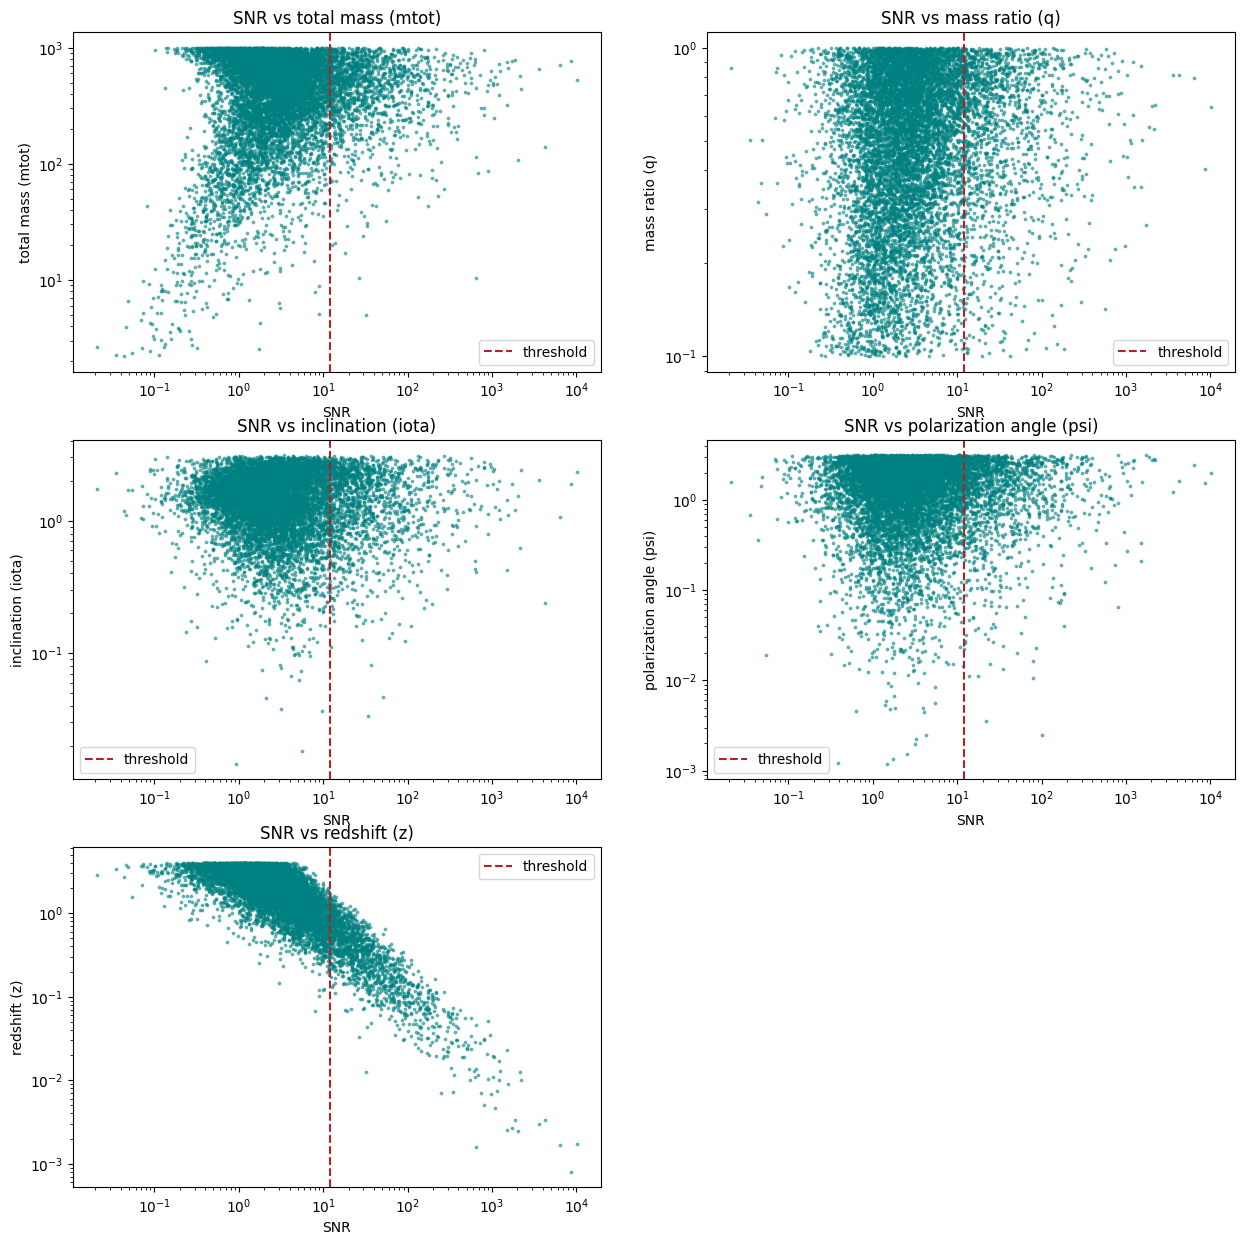

In [8]:
variables = [mtot, q, iota, psi, z]

titles = ['total mass (mtot)', 'mass ratio (q)', 'inclination (iota)', 'polarization angle (psi)', 'redshift (z)']

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 15))
axes = axes.flatten()

for i, (var, title) in enumerate(zip(variables, titles)):
    ax = axes[i]
    ax.scatter(snr, var, alpha=0.5, s = 3, c= "teal")
    ax.axvline(x=12, color='firebrick', linestyle='--', label = 'threshold')
    ax.set_xlabel('SNR')
    ax.set_ylabel(title)
    ax.set_title(f'SNR vs {title}')
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.legend()

fig.delaxes(axes[-1])

In [20]:
# I shouldn' use the SNR as it would be as having labels

X = np.array([mtot, q, iota, psi, z]).T
y = det

# Split the data into training and testing sets
(X_train, X_test), (y_train, y_test) = split_samples(X, y, [0.75, 0.25], random_state=0)

## Logistic Regression

/home/malvi/venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


completeness: 0.9394886363636363
contamination: 0.4182937554969217


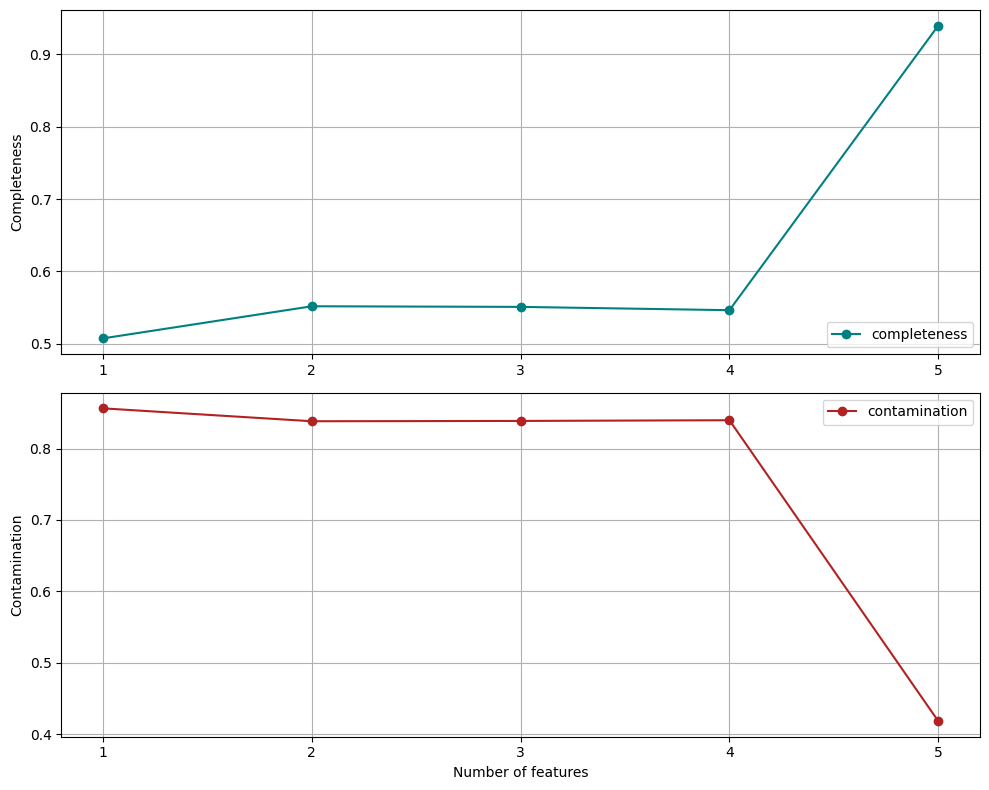

In [6]:
from sklearn.linear_model import LogisticRegression
from astroML.utils import completeness_contamination

n_features = np.arange(1, X.shape[1] + 1)

completeness = []
contamination = []

for nc in n_features:
    clf = LogisticRegression(class_weight='balanced')
    clf.fit(X_train[:, :nc], y_train)
    y_pred = clf.predict(X_test[:, :nc])

    comp, cont = completeness_contamination(y_pred, y_test)
    completeness.append(comp)
    contamination.append(cont)

fig, ax = plt.subplots(2, 1, figsize=(10, 8))

ax[0].plot(n_features, completeness, 'o-',c = 'teal', ms=6, label = 'completeness')
ax[0].set_ylabel('Completeness')
ax[0].set_xticks(n_features)
ax[0].grid(True)
ax[0].legend(loc = 'lower right')

ax[1].plot(n_features, contamination, 'o-',c = 'firebrick', ms=6, label = 'contamination')
ax[1].set_xlabel('Number of features')
ax[1].set_ylabel('Contamination')
ax[1].set_xticks(n_features)
ax[1].grid(True)
ax[1].legend()

print('completeness:', completeness[-1])
print('contamination:', contamination[-1])

plt.tight_layout()
plt.show()

/home/malvi/venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/malvi/venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n

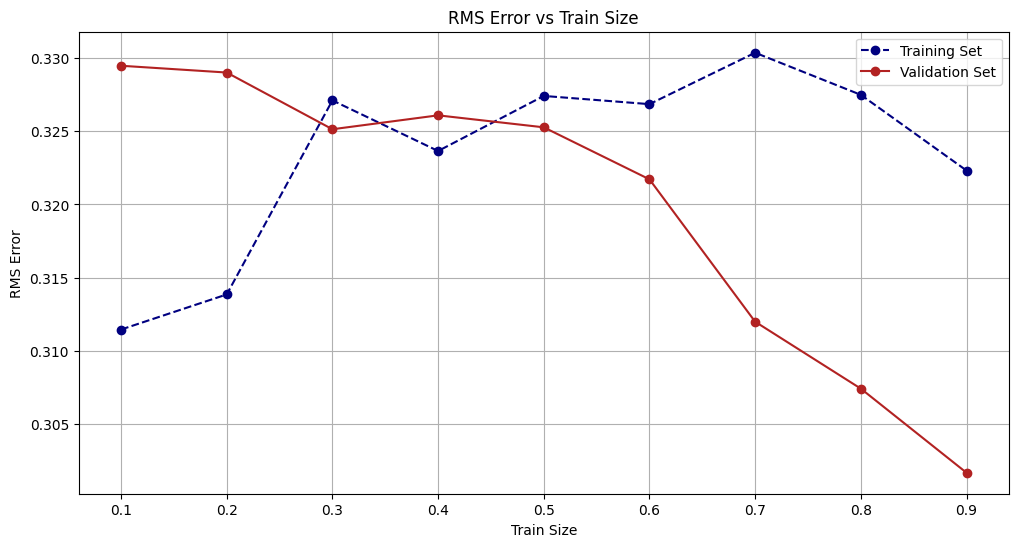

In [19]:
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt

train_sizes = np.linspace(0.1, 0.9, 9)

rms_errors_train = []
rms_errors_val = []

for train_size in train_sizes:
    (X_train_var, X_val_var), (y_train_var, y_val_var) = split_samples(X, y, [train_size, 1 - train_size], random_state=0)
    
    clf = LogisticRegression(class_weight='balanced')
    clf.fit(X_train_var, y_train_var)
    
    y_train_pred = clf.predict(X_train_var)
    rms_errors_train.append(np.sqrt(mean_squared_error(y_train_var, y_train_pred)))
    
    y_val_pred = clf.predict(X_val_var)
    rms_errors_val.append(np.sqrt(mean_squared_error(y_val_var, y_val_pred)))

plt.figure(figsize=(12, 6))
plt.plot(train_sizes, rms_errors_train,'o--', label='Training Set', color='navy')
plt.plot(train_sizes, rms_errors_val, 'o-k', label='Validation Set', color='firebrick')
plt.xlabel('Train Size')
plt.ylabel('RMS Error')
plt.title('RMS Error vs Train Size')
plt.legend()
plt.grid(True)
plt.show()

In [28]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from astroML.utils import completeness_contamination

# Define the parameter grid for Logistic Regression
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']  # 'liblinear' is a good choice for small datasets and supports both l1 and l2 penalties
}

# Perform GridSearchCV to find the best parameters
grid_search = GridSearchCV(LogisticRegression(class_weight='balanced'), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Get the best estimator
best_log_reg = grid_search.best_estimator_
print(f"Best parameters for Logistic Regression: {grid_search.best_params_}")

# Evaluate the best Logistic Regression model on the test set
y_pred = best_log_reg.predict(X_test)
completeness, contamination = completeness_contamination(y_pred, y_test)
print(f"Completeness: {completeness}")
print(f"Contamination: {contamination}")

Best parameters for Logistic Regression: {'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}
Completeness: 0.9305555555555556
Contamination: 0.3853211009174312


## Let's use different classifiers

In [29]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Define the classifiers and their parameter grids
classifiers = {
    'RandomForest': RandomForestClassifier(random_state=0),
    'SVM': SVC(random_state=0),
    'DecisionTree': DecisionTreeClassifier(random_state=0)
}

param_grids = {
    'RandomForest': {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20, 30],
        'max_features': ['auto', 'sqrt', 'log2']
    },
    'SVM': {
        'C': [0.1, 1, 10, 100],
        'kernel': ['linear', 'rbf', 'poly'],
        'degree': [3, 4, 5]
    },
    'DecisionTree': {
        'max_depth': [None, 10, 20, 30],
        'max_features': ['auto', 'sqrt', 'log2']
    }
}



### Let's do cross validation to determine the parameters of the classifiers

In [30]:
import os

file_name = 'grid_search_results_es_20.npy'

if os.path.exists(file_name):
    best_classifiers = np.load(file_name, allow_pickle=True).item()
    print("Loaded existing grid search results.")
else:

    best_classifiers = {}
    for clf_name, clf in classifiers.items():
        grid_search = GridSearchCV(clf, param_grids[clf_name], cv=5, scoring='accuracy')
        grid_search.fit(X_train, y_train)
        best_classifiers[clf_name] = grid_search.best_estimator_
        print(f"Best parameters for {clf_name}: {grid_search.best_params_}")

    np.save(file_name, best_classifiers)
    print("Saved grid search results to file.")



for clf_name, clf in best_classifiers.items():
    y_pred = clf.predict(X_test)
    print(f"Classification report for {clf_name}:\n{classification_report(y_test, y_pred)}")

/home/malvi/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
60 fits failed out of a total of 180.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "/home/malvi/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/malvi/venv/lib/python3.12/site-packages/sklearn/base.py", line 1466, in wrapper
    estimator._validate_params()
  File "/home/malvi/venv/lib/python3.12/site-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "/home/malvi/venv/lib/python3.1

Best parameters for RandomForest: {'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 100}
Best parameters for SVM: {'C': 10, 'degree': 3, 'kernel': 'linear'}
Best parameters for DecisionTree: {'max_depth': 10, 'max_features': 'sqrt'}
Saved grid search results to file.
Classification report for RandomForest:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      2140
           1       0.90      0.82      0.86       360

    accuracy                           0.96      2500
   macro avg       0.94      0.90      0.92      2500
weighted avg       0.96      0.96      0.96      2500

Classification report for SVM:
              precision    recall  f1-score   support

           0       0.96      0.97      0.96      2140
           1       0.80      0.77      0.79       360

    accuracy                           0.94      2500
   macro avg       0.88      0.87      0.88      2500
weighted avg       0.94      0.94      0.94      2500


/home/malvi/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
20 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "/home/malvi/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/malvi/venv/lib/python3.12/site-packages/sklearn/base.py", line 1466, in wrapper
    estimator._validate_params()
  File "/home/malvi/venv/lib/python3.12/site-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "/home/malvi/venv/lib/python3.12

In [31]:
from astroML.utils import completeness_contamination

# Evaluate the best classifiers on the test set and calculate completeness and contamination
for clf_name, clf in best_classifiers.items():
    y_pred = clf.predict(X_test)
    completeness, contamination = completeness_contamination(y_pred, y_test)
    print(f"Classifier: {clf_name}")
    print(f"Completeness: {completeness}")
    print(f"Contamination: {contamination}")
    print("\n")

Classifier: RandomForest
Completeness: 0.8222222222222222
Contamination: 0.0975609756097561


Classifier: SVM
Completeness: 0.7666666666666667
Contamination: 0.19533527696793002


Classifier: DecisionTree
Completeness: 0.7944444444444444
Contamination: 0.1686046511627907




### Does it change anything using the data in log-scale? (just a bit)

In [32]:
X_log = np.log1p(X) 

(X_train_log, X_test_log), (y_train_log, y_test_log) = split_samples(X_log, y, [0.75, 0.25], random_state=0)

best_classifiers_log = {}
for clf_name, clf in classifiers.items():
    grid_search_log = GridSearchCV(clf, param_grids[clf_name], cv=5, scoring='accuracy')
    grid_search_log.fit(X_train_log, y_train_log)
    best_classifiers_log[clf_name] = grid_search_log.best_estimator_
    print(f"Best parameters for {clf_name} (log-transformed): {grid_search_log.best_params_}")

for clf_name, clf in best_classifiers_log.items():
    y_pred_log = clf.predict(X_test_log)
    completeness_log, contamination_log = completeness_contamination(y_pred_log, y_test_log)
    print(f"Classifier (log-transformed): {clf_name}")
    print(f"Completeness (log-transformed): {completeness_log}")
    print(f"Contamination (log-transformed): {contamination_log}")
    print("\n")

/home/malvi/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
60 fits failed out of a total of 180.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "/home/malvi/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/malvi/venv/lib/python3.12/site-packages/sklearn/base.py", line 1466, in wrapper
    estimator._validate_params()
  File "/home/malvi/venv/lib/python3.12/site-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "/home/malvi/venv/lib/python3.1

Best parameters for RandomForest (log-transformed): {'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 100}
Best parameters for SVM (log-transformed): {'C': 100, 'degree': 3, 'kernel': 'rbf'}
Best parameters for DecisionTree (log-transformed): {'max_depth': 10, 'max_features': 'sqrt'}
Classifier (log-transformed): RandomForest
Completeness (log-transformed): 0.8222222222222222
Contamination (log-transformed): 0.0975609756097561


Classifier (log-transformed): SVM
Completeness (log-transformed): 0.8138888888888889
Contamination (log-transformed): 0.11746987951807229


Classifier (log-transformed): DecisionTree
Completeness (log-transformed): 0.7972222222222223
Contamination (log-transformed): 0.17052023121387283




/home/malvi/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
20 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "/home/malvi/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/malvi/venv/lib/python3.12/site-packages/sklearn/base.py", line 1466, in wrapper
    estimator._validate_params()
  File "/home/malvi/venv/lib/python3.12/site-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "/home/malvi/venv/lib/python3.12

----------------------------------------------------------------
--------------------------------------------------

### Since using all my data isn't a viable option for my computer I'll try to use a subset of my varibles 

In [22]:
import seaborn as sns
import pandas as pd

# Create a DataFrame with the relevant data
data_dict = {
    'snr': snr,
    'mtot': mtot,
    'q': q,
    'iota': iota,
    'psi': psi,
    'z': z
}

df = pd.DataFrame(data_dict)

# Compute the correlation matrix
corr_matrix = df.corr()
print(corr_matrix)

print('\n-------------\n')

# Find the most correlated variables
most_correlated = corr_matrix.abs().unstack().sort_values(ascending=False)
most_correlated = most_correlated[most_correlated < 1].reset_index()
most_correlated.columns = ['Variable 1', 'Variable 2', 'Correlation']
print(most_correlated.head())

           snr      mtot         q      iota       psi         z
snr   0.000000 -0.000152 -0.000366 -0.000136 -0.000234  0.000348
mtot -0.000152  1.000000 -0.000179  0.000370  0.000128 -0.000276
q    -0.000366 -0.000179  1.000000 -0.000002  0.000115  0.000031
iota -0.000136  0.000370 -0.000002  1.000000 -0.000200 -0.000172
psi  -0.000234  0.000128  0.000115 -0.000200  1.000000  0.000309
z     0.000348 -0.000276  0.000031 -0.000172  0.000309  1.000000

-------------

  Variable 1 Variable 2  Correlation
0       iota       mtot     0.000370
1       mtot       iota     0.000370
2          q        snr     0.000366
3        snr          q     0.000366
4          z        snr     0.000348


### z and snr are correlated, and since I have the condition on the snr I might want to have a look at the scatter plots of the other variables vs z

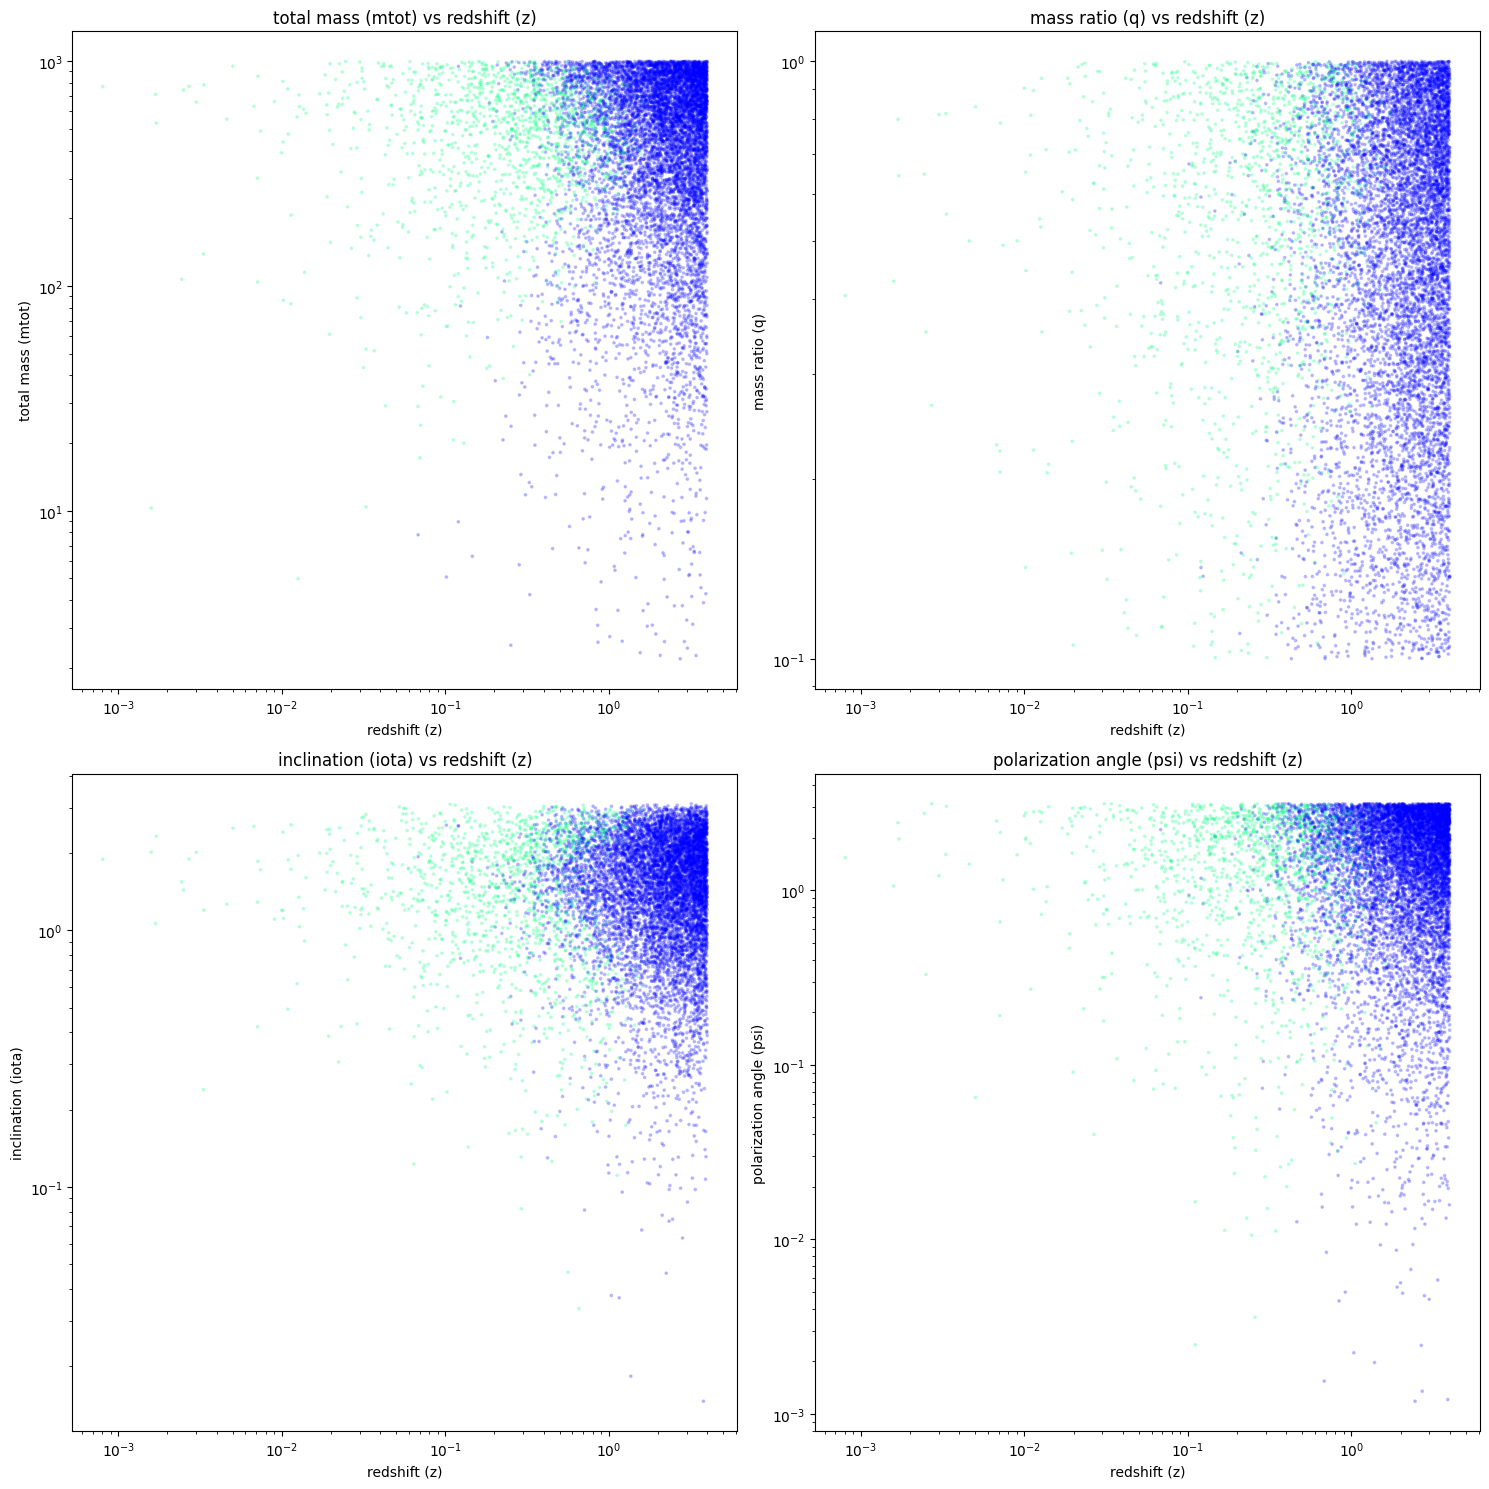

In [18]:
# Variables to plot
variables = [mtot, q, iota, psi]
titles = ['total mass (mtot)', 'mass ratio (q)', 'inclination (iota)', 'polarization angle (psi)']

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 15))
axes = axes.flatten()

for i, (var, title) in enumerate(zip(variables, titles)):
    ax = axes[i]
    scatter = ax.scatter(z, var, c=det, alpha=0.2, s=3, cmap='winter')
    ax.set_xlabel('redshift (z)')
    ax.set_ylabel(title)
    ax.set_title(f'{title} vs redshift (z)')
    ax.set_yscale('log')
    ax.set_xscale('log')


plt.tight_layout()
plt.show()

In [24]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from astroML.utils import completeness_contamination
from sklearn.preprocessing import StandardScaler

subsets = [
    [0, 4],  # mtot, z
    [1, 4],  # q, z
    [2, 4],  # iota, z
    [3, 4]   # psi, z
]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

results = {}

for subset in subsets:
    X_subset = X_scaled[:, subset]
    (X_train_subset, X_test_subset), (y_train_subset, y_test_subset) = split_samples(X_subset, y, [0.75, 0.25], random_state=0)
    
    clf = LogisticRegression(class_weight='balanced')
    clf.fit(X_train_subset, y_train_subset)
    y_pred_subset = clf.predict(X_test_subset)
    
    completeness_subset, contamination_subset = completeness_contamination(y_pred_subset, y_test_subset)
    
    results[tuple(subset)] = {
        'classifier': clf,
        'completeness': completeness_subset,
        'contamination': contamination_subset,
        'classification_report': classification_report(y_test_subset, y_pred_subset)
    }

for subset, result in results.items():
    print(f"Subset: {subset}")
    print(f"Completeness: {result['completeness']}")
    print(f"Contamination: {result['contamination']}")
    print(f"Classification Report:\n{result['classification_report']}")
    print("\n")


Subset: (0, 4)
Completeness: 0.9277777777777778
Contamination: 0.40569395017793597
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.89      0.94      2140
           1       0.59      0.93      0.72       360

    accuracy                           0.90      2500
   macro avg       0.79      0.91      0.83      2500
weighted avg       0.93      0.90      0.91      2500



Subset: (1, 4)
Completeness: 0.9361111111111111
Contamination: 0.38838475499092556
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.90      0.94      2140
           1       0.61      0.94      0.74       360

    accuracy                           0.91      2500
   macro avg       0.80      0.92      0.84      2500
weighted avg       0.93      0.91      0.91      2500



Subset: (2, 4)
Completeness: 0.9277777777777778
Contamination: 0.40569395017793597
Classification Report:
              precision 

In [26]:
best_subset = None
best_completeness = 0
best_contamination = float('inf')

for subset, result in results.items():
    completeness_subset = result['completeness']
    contamination_subset = result['contamination']
    
    if completeness_subset > best_completeness or (completeness_subset == best_completeness and contamination_subset < best_contamination):
        best_completeness = completeness_subset
        best_contamination = contamination_subset
        best_subset = subset

print(f"Best subset: {best_subset}")
print(f"Best completeness: {best_completeness}")
print(f"Best contamination: {best_contamination}")
print("which could be worse given that we are using only two features")

Best subset: (1, 4)
Best completeness: 0.9361111111111111
Best contamination: 0.38838475499092556
which could be worse given that we are using only two features


-------------------------------------------------
------------------------------------------

## last but not least: let's try PCA

new shape: (10000, 5)
(5, 5)
Explained fractional variance of data encapsulated in the eigenvalues: [9.99967269e-01 1.62503351e-05 9.99294367e-06 5.66284850e-06
 8.24563931e-07] 
sum:  1.0


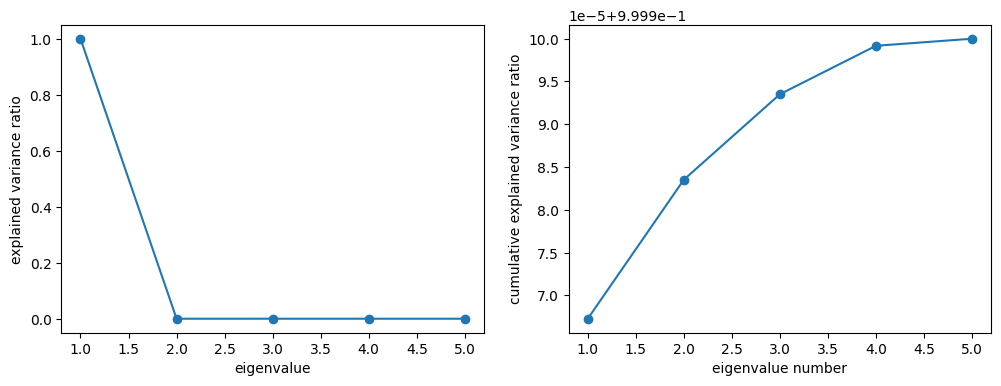

In [27]:
from sklearn.decomposition import PCA
pca= PCA() 
pca.fit(X) 

eigenvalues = pca.transform(X)
mean = pca.mean_
eigenvectors = pca.components_
evals = pca.explained_variance_ratio_ 

# Reconstruction of object1
# Xreconstruct[0] = mean + eigenvectors*eigenvalues[0]

print("new shape:", eigenvalues.shape)
print(eigenvectors.shape)

print('Explained fractional variance of data encapsulated in the eigenvalues: ' + str(evals), "\nsum: ", np.sum(evals))

fig = plt.figure(figsize=(12, 4))

ax = fig.add_subplot(121)

n_components= np.ones(len(pca.explained_variance_ratio_ )) + range(len(pca.explained_variance_ratio_ ))

ax.plot(n_components, evals)
ax.scatter(n_components, evals)

ax.set_xlabel("eigenvalue")
ax.set_ylabel("explained variance ratio")

ax = fig.add_subplot(122)

ax.plot(n_components, evals.cumsum())
ax.scatter(n_components, evals.cumsum())

ax.set_xlabel("eigenvalue number")
ax.set_ylabel("cumulative explained variance ratio")

plt.show()

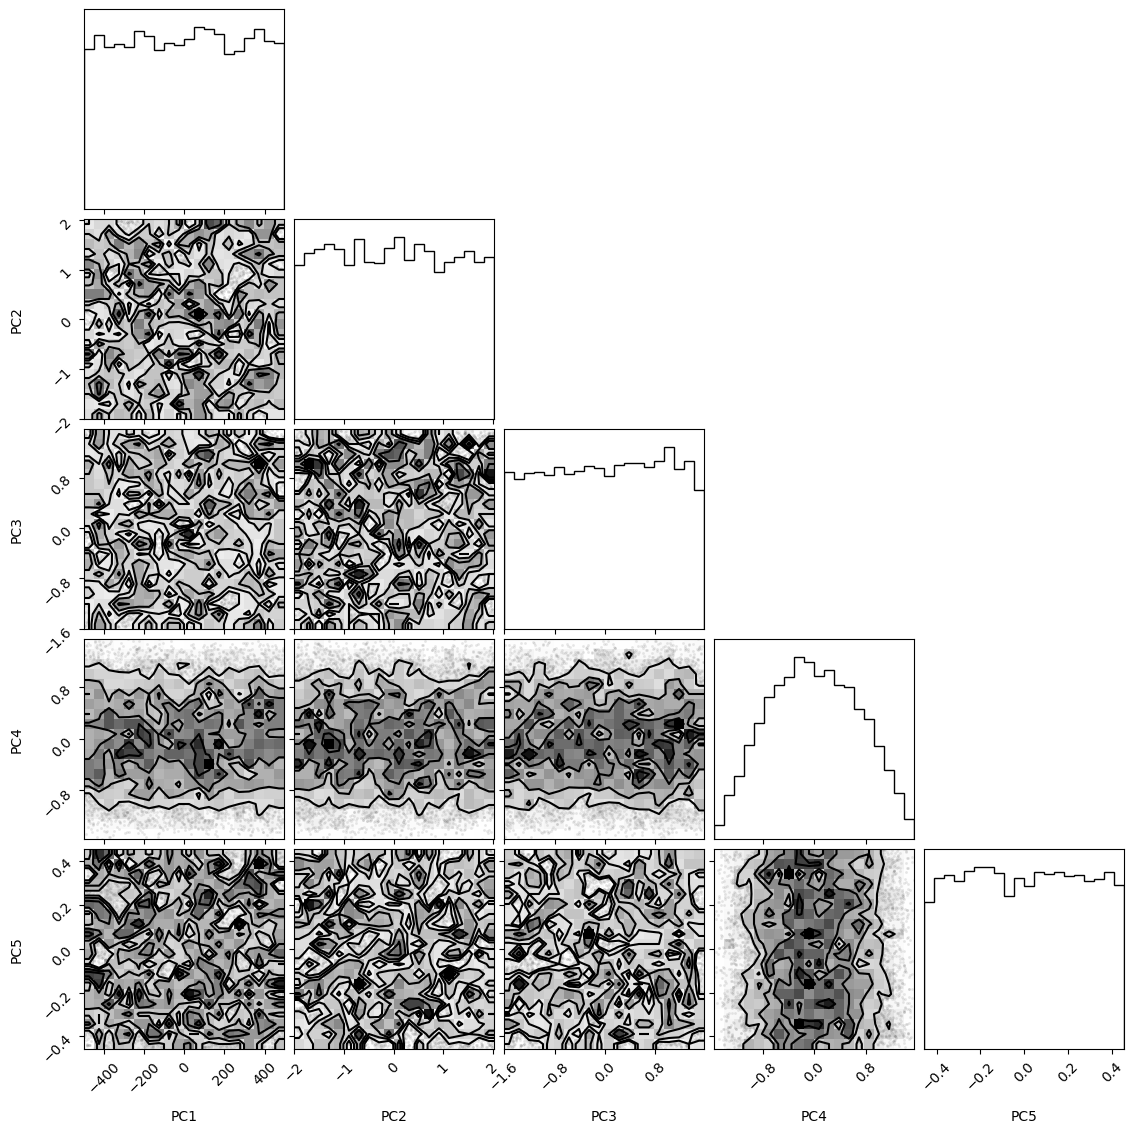

In [31]:
import corner
# Create a DataFrame with the eigenvalues
eigenvalues_df = pd.DataFrame(eigenvalues, columns=[f'PC{i+1}' for i in range(eigenvalues.shape[1])])

# Use corner to create a corner plot
figure = corner.corner(eigenvalues_df, labels=[f'PC{i+1}' for i in range(eigenvalues.shape[1])])
plt.show()


In [34]:
from sklearn.model_selection import train_test_split

X_pca_subset = eigenvalues[:, :2]

X_train_pca_subset, X_test_pca_subset, y_train_pca_subset, y_test_pca_subset = train_test_split(
    X_pca_subset, y, test_size=0.25, random_state=0)

clf_pca = LogisticRegression(class_weight='balanced')
clf_pca.fit(X_train_pca_subset, y_train_pca_subset)

y_pred_pca_subset = clf_pca.predict(X_test_pca_subset)

completeness_pca_subset, contamination_pca_subset = completeness_contamination(y_pred_pca_subset, y_test_pca_subset)

# Print results
print(f"Completeness (PCA subset): {completeness_pca_subset}")
print(f"Contamination (PCA subset): {contamination_pca_subset}")
print(f"Classification Report (PCA subset):\n{classification_report(y_test_pca_subset, y_pred_pca_subset)}")

Completeness (PCA subset): 0.9310344827586207
Contamination (PCA subset): 0.42142857142857143
Classification Report (PCA subset):
              precision    recall  f1-score   support

           0       0.99      0.89      0.94      2152
           1       0.58      0.93      0.71       348

    accuracy                           0.90      2500
   macro avg       0.78      0.91      0.83      2500
weighted avg       0.93      0.90      0.91      2500



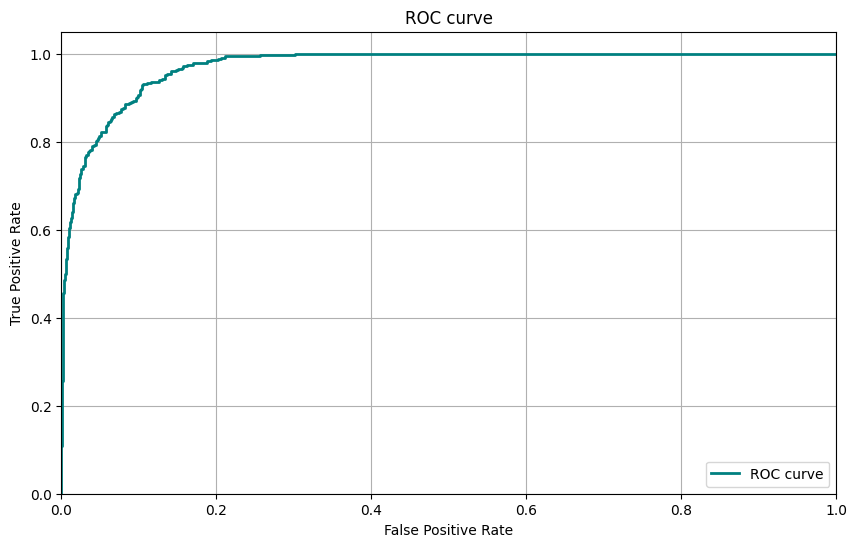

In [42]:
from sklearn.metrics import roc_curve, roc_auc_score

# Predict probabilities instead of class labels
y_prob = clf_pca.predict_proba(X_test_pca_subset)[:, 1]

# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_test_pca_subset, y_prob)

# Plot ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='teal', lw=2, label=f'ROC curve')
plt.xlim([0.0, 1])
plt.ylim([0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

completeness: 0.9310344827586207
contamination: 0.42142857142857143


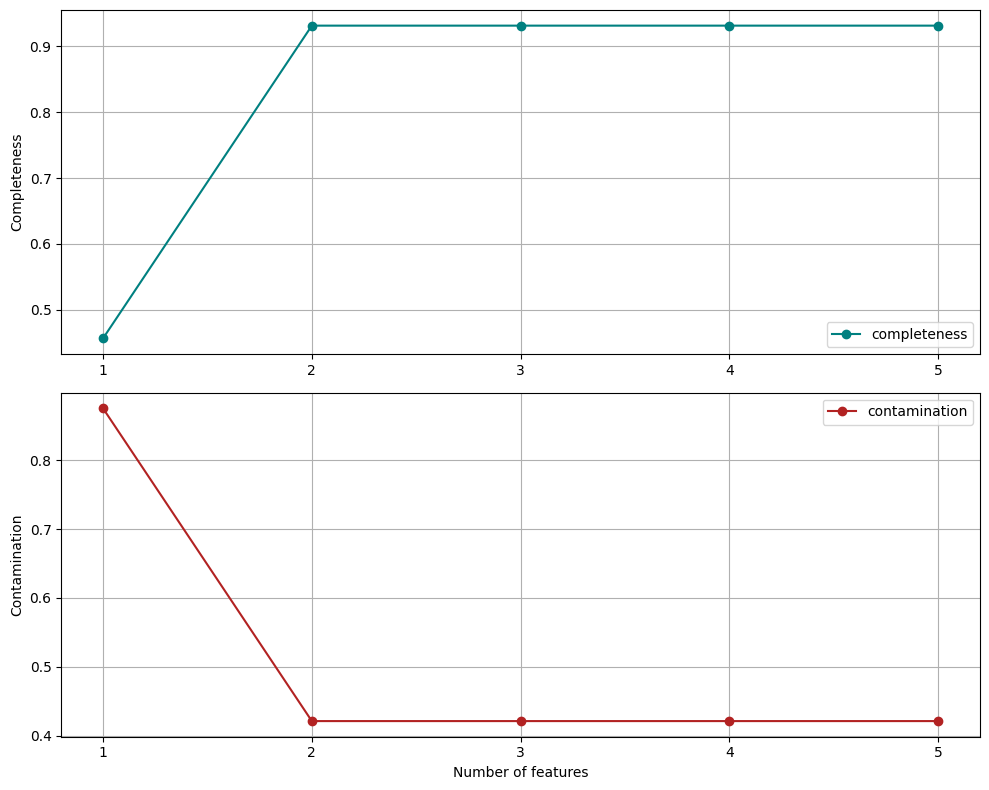

In [35]:
from sklearn.linear_model import LogisticRegression
from astroML.utils import completeness_contamination

n_features = np.arange(1, eigenvalues.shape[1] + 1)

completeness = []
contamination = []

for nc in n_features:
    clf = LogisticRegression(class_weight='balanced')
    clf.fit(X_train_pca_subset[:, :nc], y_train_pca_subset)
    y_pred = clf.predict(X_test_pca_subset[:, :nc])

    comp, cont = completeness_contamination(y_pred, y_test_pca_subset)
    completeness.append(comp)
    contamination.append(cont)

fig, ax = plt.subplots(2, 1, figsize=(10, 8))

ax[0].plot(n_features, completeness, 'o-', c='teal', ms=6, label='completeness')
ax[0].set_ylabel('Completeness')
ax[0].set_xticks(n_features)
ax[0].grid(True)
ax[0].legend(loc='lower right')

ax[1].plot(n_features, contamination, 'o-', c='firebrick', ms=6, label='contamination')
ax[1].set_xlabel('Number of features')
ax[1].set_ylabel('Contamination')
ax[1].set_xticks(n_features)
ax[1].grid(True)
ax[1].legend()

print('completeness:', completeness[-1])
print('contamination:', contamination[-1])

plt.tight_layout()
plt.show()

#### **using more features doesn't change the result, let's see if we might need more data:**

/tmp/ipykernel_241453/1714094227.py:28: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "o-k" (-> color='k'). The keyword argument will take precedence.
  plt.plot(train_sizes, rms_errors_val, 'o-k', label='Validation Set', color='firebrick')


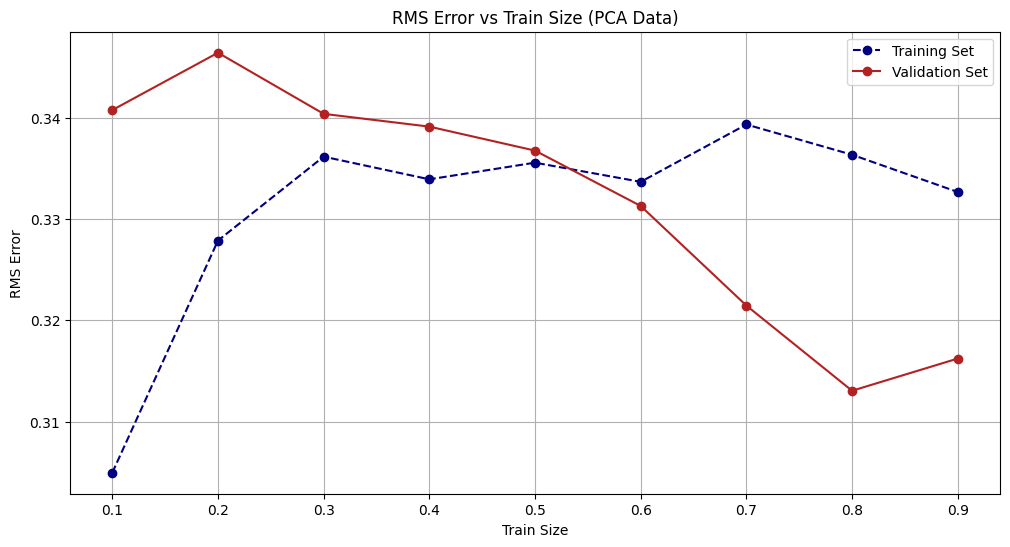

In [37]:
from sklearn.metrics import mean_squared_error

train_sizes = np.linspace(0.1, 0.9, 9)

rms_errors_train = []
rms_errors_val = []

for train_size in train_sizes:
    (X_train_var, X_val_var), (y_train_var, y_val_var) = split_samples(X_pca_subset, y, [train_size, 1 - train_size], random_state=0)
    
    clf = LogisticRegression(class_weight='balanced')
    clf.fit(X_train_var, y_train_var)
    
    y_train_pred = clf.predict(X_train_var)
    rms_errors_train.append(np.sqrt(mean_squared_error(y_train_var, y_train_pred)))
    
    y_val_pred = clf.predict(X_val_var)
    rms_errors_val.append(np.sqrt(mean_squared_error(y_val_var, y_val_pred)))

plt.figure(figsize=(12, 6))
plt.plot(train_sizes, rms_errors_train, 'o--', label='Training Set', color='navy')
plt.plot(train_sizes, rms_errors_val, 'o-k', label='Validation Set', color='firebrick')
plt.xlabel('Train Size')
plt.ylabel('RMS Error')
plt.title('RMS Error vs Train Size (PCA Data)')
plt.legend()
plt.grid(True)
plt.show()
